## Introduction

Brittany Sun, Hilary Cabrera Orozco, Jessie Lee

#### Context

Air travel is an essential part of modern life, connecting people and regions while driving economic growth. Recently, internet trends talked about "travel Tuesday," which is a day of cheaper bookings discovered by experts at airfare tracking sites (Lee 2024). This led our group to dive into the implications of socioeconomic status and its implications on air travel. We believe that this is applicable to most people, and wanted to pursue a project that reflected greater society. However, access to affordable and timely air travel may not be equitable across different socioeconomic groups. This raises critical questions about whether income or regional demographics play a role in determining flight route availability, ticket pricing, or on-time performance.

Originally, we wanted to look into the prices of flights in upstate New York in congruency with Cornell University's scheduled breaks. However, we quickly realized this prediction is not only limited, leaving less room for broader implications, the results were rather intuitively correlated. Therefore, we decided to broaden our approach, and look into the cost of flights in relation to passenger demographics. 

#### Motivation
We aim to investigate how socioeconomic status may impact air travel; our research will focus on key aspects, which include flight prices, route availability, and flight cancellations. Based on our knowledge right now, we hypothesize that affluent areas will contain more flight options, better connectivity, and more reliable departure times, limiting inconveniences for passengers. We aim to examine these factors to identify possible disparities in air travel that could impact lower-income areas of the United States. Through this research, we aspire to understand broader transportation models and the inequities that arise from these existing systems. By understanding this, we hope to be able to suggest ways to lessen this disparity across disadvantaged populations. 

### **Research Question:**
Our main research question is: **Does socioeconomic status impact air travel accessibility and affordability?


We are interested in more specific research questions listed below:
- Which airports are the most cost-effective to fly out of? Which airports have the most routes?
    - Are there more routes in more affluent areas compared to other areas?
- Do areas of different socioeconomic statuses affect flight prices for different airports?
- Where are flights more expensive in relation to the income of a county?

We will sift through data to analyze how flight departure, route availability, flight pricing, and punctuality are impacted by socioeconomic status of individuals and the region. We will further analyze these trends with out two preregistration statements, followed by bootstrapping for each and analyses of our findings. In the end, we will comprehensively tie our conclusions to our initial question and leave off with limitations for future considerations. Overall, we want to know if time and accessibility  exploits are causes of lower socioeconomic status. 

**This is the link to our full project: [Full project](https://github.com/chen-wen-yu/info2950_project)**

In [1]:
# importing packages for data cleaning and analysis from info2950 kernel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error
import duckdb
import requests
from bs4 import BeautifulSoup
import time

import os

## Data Description and Cleaning

Below we run through a few brief cleaning steps in our data. The official raw data source link can be found here: [info2950_project Github repository](https://github.com/chen-wen-yu/info2950_project/tree/main/data). 

**The complete data cleaning process from phase 2 can be found here: [info2950_project phase 2](https://github.com/chen-wen-yu/info2950_project/blob/main/phase2.ipynb)**

Our project consists of datasets from several sources, each playing a critical role in exploring the connection between air travel and socioeconomic factors:

**Flight Route Data**

* Description: Sourced from OpenFlights, includes details on airline routes globally. We filtered this data to focus on U.S. domestic flights, using columns such as departure and destination airports, number of stops, and equipment used (aircraft type). This allows us to assess the connectivity of various airports and explore whether wealthier areas have better access to flights (measured by the number of routes).

* The OpenFlights database is a resource with info on over 10,000 airports, train stations, and ferry terminals worldwide. It provides details like the name, location, codes (IATA/ICAO), coordinates, altitude, timezone, and more. We downloaded the data as a CSV file.
* URL: https://openflights.org/data.php#airport

First, we access a global database of airports by webscraping https://openflights.org/data.php#airport. With this source, we are able to collect data on Airline, Airline ID, Source airport, Source airport ID, Destination airport, Destination airport ID, Codeshare, Stops, and Equipment.

In [2]:
# webscraping for dataset column names
routes_url = "https://openflights.org/data.php#airport"

routes_result = requests.get(routes_url)
routes_text = routes_result.text
page = BeautifulSoup(routes_text, "html.parser")

tables = page.find_all('table')

# tables have no attributes/tags/classes to specifically look for
# the table needs to be indexed instead
table = tables[6]
table_rows = table.find_all("tr")

column_names = []

for row in table_rows:
    name = row.find('td', {'class': 'head'})
    
    if name != None:
        name = name.text

    column_names.append(name)

print(column_names)

['Airline', 'Airline ID', 'Source airport', 'Source airport ID', 'Destination airport', 'Destination airport ID', 'Codeshare', 'Stops', 'Equipment']


Once we narrowed the columns of information needed, we import our data from routes.csv to the respective columns. 

In [3]:
# importing data from csv file into dataframe
routes = pd.read_csv('data/routes.csv', header = None)

# adding webscraped column names to dataframe
routes.columns = column_names
print(routes.head(5))

  Airline Airline ID Source airport Source airport ID Destination airport  \
0      2B        410            AER              2965                 KZN   
1      2B        410            ASF              2966                 KZN   
2      2B        410            ASF              2966                 MRV   
3      2B        410            CEK              2968                 KZN   
4      2B        410            CEK              2968                 OVB   

  Destination airport ID Codeshare  Stops Equipment  
0                   2990       NaN      0       CR2  
1                   2990       NaN      0       CR2  
2                   2962       NaN      0       CR2  
3                   2990       NaN      0       CR2  
4                   4078       NaN      0       CR2  


**US Airport Codes:**

* Description: Sourced from Leonard's Guide, this dataset provides a comprehensive list of U.S. airport codes. This helped us filter out the global route dataset to only include U.S. airports, enabling us to focus our analysis on domestic flight patterns and compare airports within the same regulatory and economic context.
* Provides a comprehensive list of three-letter IATA airport codes for U.S. airports, organized by state and city. This site aids in quickly identifying airports across the United States.
* URL: https://www.leonardsguide.com/us-airport-codes.shtml

In [4]:
# removing non-US airports from routes
us_airports  = "https://www.leonardsguide.com/us-airport-codes.shtml"
airports_result = requests.get(us_airports)
airports_text = airports_result.text
page = BeautifulSoup(airports_text, "html.parser")

table = page.find('table')
table_rows = table.find_all('td')

airport_list = []

for row in table_rows:
    row = row.text
    if len(row) == 3:
        airport_list.append(row)

us_airport_df = pd.DataFrame(airport_list, columns=['Airport'])
print(us_airport_df)

    Airport
0       BHM
1       DHN
2       HSV
3       MOB
4       MGM
..      ...
182     MSN
183     CPR
184     CYS
185     JAC
186     RKS

[187 rows x 1 columns]


**Average Domestic Airline Itinerary Fares:**
* Description: Collected from the Bureau of Transportation Statistics, this dataset offers information on the average fare for domestic flights in the U.S. over multiple years, adjusted for inflation. It includes key attributes such as the airport code, airport name, city and state, average fare, and inflation-adjusted fare. By combining this with other datasets, we can analyze whether flight prices vary significantly across regions of different socioeconomic statuses and track fare trends over time.
* Provides data on average domestic airline itinerary fares in the United States. This information includes average fares by quarter and year, offering insights into trends over time. The data is sourced from the Airline Origin & Destination Survey (10% Sample) and is available for public access.
* URL: https://www.transtats.bts.gov/AverageFare/

**Socioeconomic Data:**
* Description: Socioeconomic indicators such as median household income and personal income were sourced from the Bureau of Economic Analysis. This data helps us categorize airports by the wealth of their surrounding regions and examine whether flight prices, routes, and cancellations correlate with the income levels of those regions.
* Provides a collection of regional economic data, including Gross Domestic Product (GDP), personal income, and personal consumption expenditures (PCE) by state.
* URL: https://apps.bea.gov/regional/downloadzip.htm?_gl=

**Flight Cancellation Data:**
* Description: This dataset contains information on flight cancellations for 75 major U.S. airports. We use this data to examine whether airports in wealthier regions experience better on-time performance and fewer cancellations compared to airports in lower-income areas.
* Analyses of U.S. airport performance, focusing on flight delays and cancellations. Reports are based on data from the U.S. Department of Transportation's Bureau of Transportation Statistics, offer insights into how various factors, such as weather and system outages, affect air travel.
* URL: https://www.insuremytrip.com/travel-advice/travel-planning/us-airport-statistics-flight-cancellation-data/#2023

Each row in our dataset represents a U.S. airport, with columns detailing attributes like flight prices, number of routes, surrounding socioeconomic indicators. The dataset spans multiple years, which allows us to examine how these variables have evolved over time and assess long-term trends in air travel disparities.

There is a smaller dataframe in the dataset that contains the flight cancellation data for 75 major US airports for the year 2022. The smaller dataframe was created due to the lack of available data on flight cancellations before the year 2019. The flight cancellation dataframe will be used to analyze the relationship between cancellation rates and other factors like personal income.

In [5]:
performance_url = \
    "https://www.insuremytrip.com/travel-advice/travel-planning/us-airport-statistics-flight-cancellation-data/#2023"

performance_result = requests.get(performance_url)
performance_text = performance_result.text
page = BeautifulSoup(performance_text, "html.parser")

# finding the 2022 table of flight cancellations
tables = page.find_all('table', {'class': 'c25'})
table_2022 = tables[1]
table_rows = table_2022.find_all('tr', {'class': 'c11'})

airport_list = []
canceled_list = []

# for every row, find the airport code and percent of canceled flights
# append the data to the lists
for row in table_rows[1:]:
    airport = row.find('td', {'class': 'c12'})
    airport = airport.find('span')
    airport = airport.text
    airport_list.append(airport)

    canceled = row.find('td', {'class': 'c5'})
    canceled = canceled.find('span')
    canceled = canceled.text
    canceled_list.append(canceled)

print(airport_list)

print(canceled_list)

canceled_2022_df = pd.DataFrame({'airport_code': airport_list, \
    'percent_canceled_flights': canceled_list})
canceled_2022_df.head()

['BUF', 'RSW', 'LGA', 'EWR', 'DCA', 'DAL', 'PBI', 'BWI', 'MDW', 'MCO', 'JFK', 'CHS', 'ORF', 'CLE', 'CMH', 'TPA', 'PIT', 'IND', 'BDL', 'BOS', 'STL', 'SAV', 'SDF', 'RIC', 'JAX', 'RDU', 'BUR', 'BNA', 'DFW', 'CVG', 'FLL', 'ORD', 'MCI', 'MIA', 'HOU', 'ANC', 'PHL', 'MEM', 'MKE', 'CLT', 'AUS', 'DEN', 'MYR', 'IAD', 'OKC', 'MSY', 'SNA', 'SJU', 'ELP', 'OMA', 'LAS', 'SAT', 'OAK', 'SEA', 'SJC', 'DTW', 'SMF', 'PDX', 'IAH', 'SAN', 'ONT', 'PHX', 'ABQ', 'MSP', 'TUS', 'RNO', 'ATL', 'SFO', 'LAX', 'GEG', 'BOI', 'SLC', 'HNL', 'OGG', 'KOA']
['5.55%', '5.47%', '5.19%', '4.82%', '3.93%', '3.82%', '3.79%', '3.74%', '3.73%', '3.70%', '3.69%', '3.61%', '3.55%', '3.53%', '3.51%', '3.45%', '3.38%', '3.36%', '3.35%', '3.34%', '3.29%', '3.28%', '3.18%', '3.15%', '3.12%', '3.08%', '3.08%', '2.99%', '2.96%', '2.92%', '2.89%', '2.86%', '2.82%', '2.82%', '2.81%', '2.74%', '2.74%', '2.74%', '2.74%', '2.73%', '2.72%', '2.71%', '2.59%', '2.49%', '2.40%', '2.37%', '2.34%', '2.32%', '2.28%', '2.22%', '2.20%', '2.19%', '2.15

,airport_code,percent_canceled_flights
0,BUF,5.55%
1,RSW,5.47%
2,LGA,5.19%
3,EWR,4.82%
4,DCA,3.93%


## Cleaned Datasets

We used multiple datasets to address our research question: Does socioeconomic status impact air travel accessibility, affordability, and punctuality?

1. Routes Data:
* Source: OpenFlights
* Cleaning: Web scraped airport route data and counted total outbound routes per airport. Non-U.S. airports were removed using a cross-referenced list of U.S. airport codes.

2. Income Data:
* Source: Bureau of Economic Analysis
* Cleaning: Merged metropolitan income data with airport locations using city and state names. Tidied income data into a long format for year-wise analysis.

3. Cancellations Data:
* Source: InsureMyTrip
* Cleaning: Web scraped 2022 cancellation rates for 75 U.S. airports. Converted percentages to numeric format for analysis

We then merged these datasets into *tidied_df*, which is a comprehensive dataset containing:
* Airport-level Information: Airport codes, names, routes, and average fares.
* Socioeconomic Indicators: Per capita income data (2008–2022).
* Punctuality Metrics: 2022 cancellation rates.

**Here is the link to our full cleaning from Phase 2 on Github: [info2950_project phase 2](https://github.com/chen-wen-yu/info2950_project/blob/main/phase2.ipynb)**

#### Pre-processing
The average fare data had to be converted from xls files to csv files before turning the data into dataframes. The MARPI_MSA_2008_2022.csv data included household income as well as per capita income. The dataset created for analysis filtered out rows regarding household income so that only data pertaining to per capita income was included in the dataset we created. Additionally, splicing was used to match the locations from the income data sources to the airport data sources because the difference sources wrote locations differently.

#### Data Involving People
The data that involved people's personal information was the personal income per capita. This data was collected by the sources related to the federal and state government through census surveys, tax records, and other ways the US government collects data on US citizens. US citizens would not be aware that their data is being used for the purpose of analyzing flight and airport disparities, however, the data is averaged to a "per capita" scale so the dataset does not unethically access individual data. We will only be looking at aggregated/averaged data already processed by the US government and its agencies.

####  Import Cleaned Dataframes ####

In [6]:
# Source to help expost csv from phase2 to import here: 
# https://datascience.stackexchange.com/questions/79758/combining-two-csvs-in-jupyter-notebook
tidied_df=pd.read_csv('cleaned_data/tidied_df.csv')
canceled_2022_df = pd.read_csv('cleaned_data/canceled_2022.csv')

final_df = tidied_df.merge(canceled_2022_df, on='airport_code', how='left')

print(final_df.head())

  airport_code           airport_name state_name    avg_fare  \
0          CAK  Akron-Canton Regional         OH  347.682886   
1          CAK  Akron-Canton Regional         OH  338.901192   
2          CAK  Akron-Canton Regional         OH  319.880566   
3          CAK  Akron-Canton Regional         OH  319.496726   
4          CAK  Akron-Canton Regional         OH  310.663034   

   inflation_adjusted_avg_fare  year source_airport  routes  \
0                   459.770111  2014            CAK      22   
1                   455.427454  2013            CAK      22   
2                   436.163692  2012            CAK      22   
3                   416.739085  2016            CAK      22   
4                   432.361017  2011            CAK      22   

                                         msa  per_capita_personal_income  \
0  Akron, OH (Metropolitan Statistical Area)                     47076.0   
1  Akron, OH (Metropolitan Statistical Area)                     45737.0   
2  Akron

## Preregistration Statement

#### Preregistration Statement 1

**Hypothesis:** 

Null: Regions of socioeconomic statuses with higher income have access to the same number of flight routes than regions of low socioeconomic status. $\beta_{income}$ = 0.

Alternative: Regions of high socioeconomic status have more access to flight routes than regions of low socioeconomic status. $\beta_{income}$ > 0.

**Analysis:**

Run a linear regression where the dependent variable (output) is the number of routes offered by an airport and the independent variable (input) is average per capita personal income of an airport's region. We are testing if $\beta_{income}$ > 0 (one-tailed test)

The results will be important to our main question on flight accessibility as it mentions the specific metrics of socioeconomic status and route access. The results of this evaluation can tell us the societal impacts of high and low income disparities, pointing to structural inequality signifiers. 


#### Preregistration Statement 2

**Hypothesis:**

Null: Airports in regions of higher income areas have similar prices as airports in lower income areas. $\beta_{income}$ = 0.

Alternative: Airports in regions of higher income areas have higher average flight prices. $\beta_{income}$ > 0.

**Analysis:**
Run a linear regression where the dependent variable (output) is the average flight price (in a given year. We focus on 2022 across all analysis) for each airport and the independent variable (input) is the region's average income. We will test if $\beta_{income}$ > 0 (one-tailed test)

The results will be critical to our main question on flight accessibility as it regards to the specified measurements of socioeconomic status and flight pricing. The results can point us to what it means for those in lower socioeconomic status and how being at a disadvantage propells inequalities further.

## Data Analysis

In [7]:
tidied_df=pd.read_csv('cleaned_data/tidied_df.csv')
print(tidied_df.head())

  airport_code           airport_name state_name    avg_fare  \
0          CAK  Akron-Canton Regional         OH  347.682886   
1          CAK  Akron-Canton Regional         OH  338.901192   
2          CAK  Akron-Canton Regional         OH  319.880566   
3          CAK  Akron-Canton Regional         OH  319.496726   
4          CAK  Akron-Canton Regional         OH  310.663034   

   inflation_adjusted_avg_fare  year source_airport  routes  \
0                   459.770111  2014            CAK      22   
1                   455.427454  2013            CAK      22   
2                   436.163692  2012            CAK      22   
3                   416.739085  2016            CAK      22   
4                   432.361017  2011            CAK      22   

                                         msa  per_capita_personal_income  
0  Akron, OH (Metropolitan Statistical Area)                     47076.0  
1  Akron, OH (Metropolitan Statistical Area)                     45737.0  
2  Akron, O

### Analysis for Preregistration Statement 1: ####

#### Exploratory Data Analysis 1:

Before we dive into preregistration statement 1, let's take a look at our phase 2 exploratory data analysis 1 evaluated:

"Are more flights available depending on the income of the area?

We visualized the relationship between flight cancellations and the personal income per capita for the area the airport(s) is located. It appears that the people within the $40,000-60,000 range for real person income have the most options in terms of routes. There are airport with little to no routes and airports with many routes available to them.
We also included a scaled version to closer examine the spread of the data points.

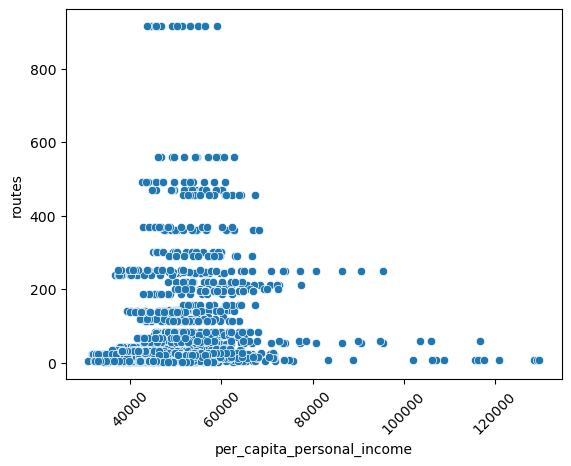

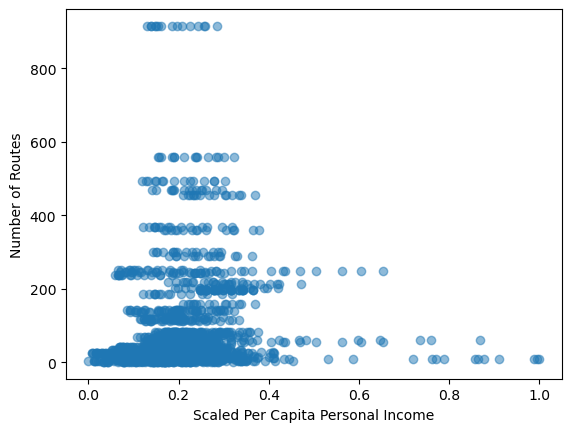

In [8]:
# routes as x-axis
# income as y axis
# airports as different colored lines

routes_income_df=tidied_df[['routes','per_capita_personal_income']]
routes_income_df.head()

routes_income_plt = sns.scatterplot(routes_income_df, \
    x = 'per_capita_personal_income', y = 'routes')

plt.xticks(rotation = 45);

# scales income [0,1] by doing (original-minimum)/(max-minimum)
tidied_df['scaled_per_capita_income'] = \
    (tidied_df['per_capita_personal_income'] - \
    tidied_df['per_capita_personal_income'].min()) / \
    (tidied_df['per_capita_personal_income'].max() - \
     tidied_df['per_capita_personal_income'].min())

plt.figure()
plt.scatter(
    tidied_df['scaled_per_capita_income'],
    tidied_df['routes'],
    alpha=0.5
)
plt.xlabel("Scaled Per Capita Personal Income")
plt.ylabel("Number of Routes")
plt.show()

#### Interpretation

- The majority of the data points are between 40,000 and 80,000 or [0.0, 0.4] for scaled
- It’s harder to distinguish trends for higher-income areas, above 80,000 because these values are spread sparsely on the x-axis
- The relationship between income and routes does not appear strong

The relationship between income and routes clusters at [0.0 , 0.4] or [40,000 , 80,000] as average income, indicating that most airports are located in regions with relatively lower per capita personal income.

##### Now that we have initial expectations, let's move onto the preregistration statement 2, examining if regions of socioeconomic statuses with higher income have access to the same number of flight routes than regions of low socioeconomic status. 

Routes Model Coefficients: [-3.56934027e-18  1.00000000e+00]
Routes Model Intercept: 4.263256414560601e-14
Routes Model R^2: 1.0


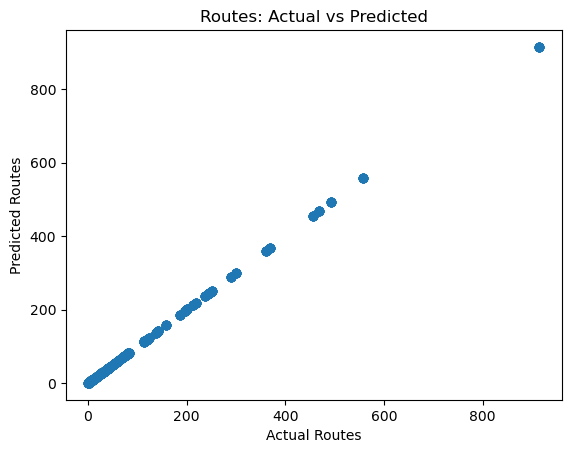

   per_capita_personal_income  routes  percent_canceled_flights
0                     39237.0      42                    0.0179
1                     49544.0      42                    0.0179
2                     40642.0      42                    0.0179
3                     39257.0      42                    0.0179
4                     52881.0      42                    0.0179
Model Coefficients with Confounder: [ 2.23798022e-03 -1.82329027e+03]
Model Intercept with Confounder: 80.78412255561497
Routes Model R^2 with Confounder: 0.027362304980511842
Model Coefficients (Original): [0.00205929]
Model Intercept (Original): 40.415741159325194
Routes Model R^2 (Original): 0.015131784815585303


In [9]:
#independent variable for route
X_routes=tidied_df[['per_capita_personal_income', 'routes']]
# dependent variable for route
y_routes=tidied_df['routes']

# remove all NA
X_routes =X_routes.dropna(subset=['per_capita_personal_income'])
y_routes=y_routes[X_routes.index]

# Linear Regression for routes
model_routes =LinearRegression()
model_routes.fit(X_routes, y_routes)

#coefficients and intercepts
print("Routes Model Coefficients:", model_routes.coef_)
print("Routes Model Intercept:", model_routes.intercept_)

#R-squared values
print("Routes Model R^2:", model_routes.score(X_routes,y_routes))

#visual predictions: 
y_pred_routes =model_routes.predict(X_routes)

# Scatterplot for Routes
plt.scatter(y_routes, y_pred_routes, alpha=0.6)
plt.title("Routes: Actual vs Predicted")
plt.xlabel("Actual Routes")
plt.ylabel("Predicted Routes")
plt.show()


# other confounding variables: % cancelled flights in 2022
merged_df=tidied_df.merge(canceled_2022_df,on='airport_code', how='inner')
merged_df['percent_canceled_flights']=(
    merged_df['percent_canceled_flights']
    .str.rstrip('%')
    .astype(float)/100
)
print(merged_df[['per_capita_personal_income', 'routes', 'percent_canceled_flights']].head())

#independent
X_routes =merged_df[['per_capita_personal_income','percent_canceled_flights']]

#dependent
y_routes = merged_df['routes']

X_routes = X_routes.dropna()
y_routes = y_routes[X_routes.index]

#regression
model_routes_with_confounders=LinearRegression()
model_routes_with_confounders.fit(X_routes, y_routes)

# we added a confounder to our analysis (% of cancelled flights) to further evaluate our hypothesis
print("Model Coefficients with Confounder:", model_routes_with_confounders.coef_)
print("Model Intercept with Confounder:", model_routes_with_confounders.intercept_)
print("Routes Model R^2 with Confounder:", model_routes_with_confounders.score(X_routes, y_routes))

#variables for the original model
X_routes_original = merged_df[['per_capita_personal_income']]
y_routes_original = merged_df['routes']
X_routes_original = X_routes_original.dropna()
y_routes_original = y_routes_original[X_routes_original.index]

#original regression 
model_routes_original=LinearRegression()
model_routes_original.fit(X_routes_original, y_routes_original)

print("Model Coefficients (Original):", model_routes_original.coef_)
print("Model Intercept (Original):", model_routes_original.intercept_)
print("Routes Model R^2 (Original):", model_routes_original.score(X_routes_original, y_routes_original))

We added a confounder to our analysis (% of cancelled flights) to further evaluate our hypothesis

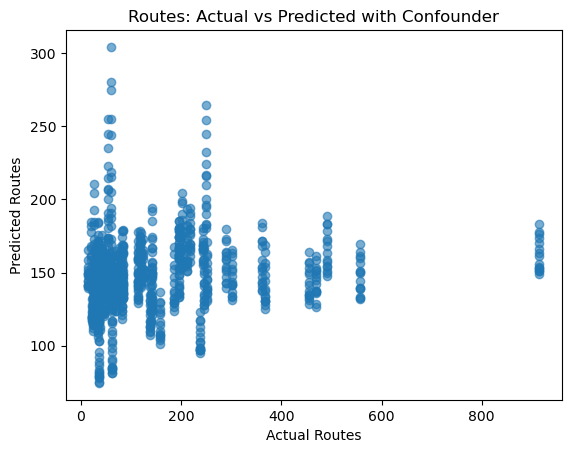

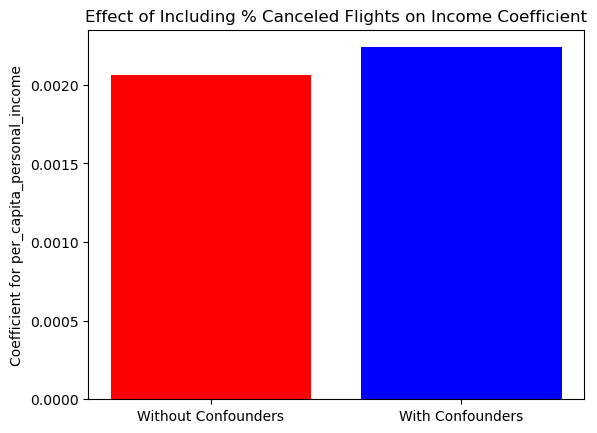

In [15]:
# predict
y_pred_routes_with_confounders = model_routes_with_confounders.predict(X_routes)

# scatterplot
plt.scatter(y_routes, y_pred_routes_with_confounders, alpha=0.6)
plt.title("Routes: Actual vs Predicted with Confounder")
plt.xlabel("Actual Routes")
plt.ylabel("Predicted Routes")
plt.show()

coefficients = [ model_routes_original.coef_[0], model_routes_with_confounders.coef_[0]]

plt.bar(["Without Confounders", "With Confounders"], coefficients, color=['red', 'blue'])
plt.title("Effect of Including % Canceled Flights on Income Coefficient")
plt.ylabel("Coefficient for per_capita_personal_income")
plt.show()

#### Interpretation of preregistration statement 1
* Scatterplot 1: shows the actual number of flight routes (x-axis) versus the predicted number of routes (y-axis) based on a linear regression model using income as the independent variable. 
The points closely follow a diagonal line, suggesting a strong fit between the model’s predictions and the actual values. This indicates that income is a relatively good predictor of the number of routes.
However, there are a few outliers which could suggest additional unaccounted factors

* Scatterplot 2: adjusted Scatterplot 1 based on confounding variable: percent of canceled flights in 2022. 
Shows more dispersed points compared to the first graph. This suggests that including the % canceled flights introduces variability into the predictions, which may reduce the model’s overall predictive power.
The confounding variable appears to moderate the relationship between income and routes, highlighting that airports with higher percentages of canceled flights may have fewer routes, regardless of regional income.
While income remains a significant predictor, the scatterplot demonstrates that % canceled flights adds complexity to the relationship, making it clear that factors beyond income influence route availability.

* Bar plot: a positive coefficient for both red and blue bars implies that higher-income regions tend to have more routes available overall. Adding the % flights cancelled confounder does not significantly alter the relationship between income and the number of routes
    
##### Overall for preregistration statement 1
* Income is a predictor of the number of routes available at an airport. The results suggest that higher-income regions generally have better air travel accessibility.
* Including % canceled flights does not drastically change the relationship but highlights that cancellations can have an indirect effect on route availability.
* The blue bar being slightly higher means that income becomes a marginally stronger predictor of the number of routes when accounting for cancelled flights. Airport route availability appears to be independent of regional income levels

Similarly to our exploratory data analysis, there does not seem to be a strong correlation between income and route available.

### Analysis for Preregistration Statement 2: #####

#### Exploratory Data Analysis 2:

Before we answer our preregistration statement, we want to take a look at our phase 2 exploratory data analysis where we analyzed the prices of flights over time for all major airports in the United States. We decided to narrow it down to only the top 5 largest airports  in the US. Below, we will look at: 

"Have the prices of flights from airports changed over time? Did an airport get more expensive compared to another?"

We utilized a line chart with axes being "Year" and "Average Cost" to analyze long-term trends and spikes. We can see that the prices of flights change over time. Something interesting we've seen is that there has been a decrease in flight prices for most airport around 2018-2020 which coincides with the COVID-19 pandemic. Additionally, in the span of our time-series (2008-2022), flight prices for most airports have stayed stagnant or decreased slightly.

,airport_code,airport_name,state_name,avg_fare,inflation_adjusted_avg_fare,year,source_airport,routes,msa,per_capita_personal_income,scaled_per_capita_income
120,ATL,Hartsfield-Jackson Atlanta International,GA,365.824746,498.809522,2012,ATL,915,"Atlanta-Sandy Springs-Alpharetta, GA (Metropol...",44616.0,0.139666
121,ATL,Hartsfield-Jackson Atlanta International,GA,368.739143,513.187645,2011,ATL,915,"Atlanta-Sandy Springs-Alpharetta, GA (Metropol...",46006.0,0.153703
122,ATL,Hartsfield-Jackson Atlanta International,GA,397.857847,534.655501,2013,ATL,915,"Atlanta-Sandy Springs-Alpharetta, GA (Metropol...",44570.0,0.139201
123,ATL,Hartsfield-Jackson Atlanta International,GA,390.236174,515.430437,2015,ATL,915,"Atlanta-Sandy Springs-Alpharetta, GA (Metropol...",49146.0,0.185413
124,ATL,Hartsfield-Jackson Atlanta International,GA,424.954285,561.952533,2014,ATL,915,"Atlanta-Sandy Springs-Alpharetta, GA (Metropol...",46661.0,0.160318


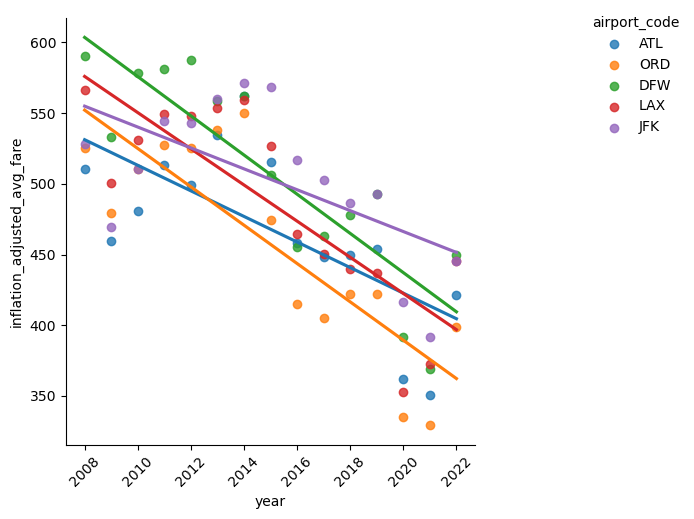

In [11]:
# year as x-axis
# average cost as y axis
# airports as different colored lines

largest_airports = tidied_df.groupby('airport_code', \
        as_index=False).agg({'routes': 'sum'})
largest_airports = largest_airports.nlargest(5, 'routes')

cost_over_time_df = tidied_df[tidied_df['airport_code']\
            .isin(largest_airports['airport_code'])]

cost_over_time_plt = sns.lmplot(cost_over_time_df, \
    x = 'year', y = 'inflation_adjusted_avg_fare', \
    hue = 'airport_code', \
    ci=None)

sns.move_legend(cost_over_time_plt, 'upper left', bbox_to_anchor=(1,1))
plt.xticks(rotation = 45);

cost_over_time_df.head()

#### Interpretation of Exploratory Analysis

* All five airports (ATL, ORD, DFW, LAX, and JFK) show a downward trend in inflation-adjusted average fares over time, indicating that flight prices have generally decreased from 2008 to 2022

* Analysis based on:
    - Lowest price: ATL in Atlanta consistently has lower prices compared to other airports, making it a cost-effective hub
    - Highest price: JFK in NYC has higher average fares over time, reflecting its position as a major international hub
    - COVID-19: There is a obvious drop due to the pandemic


* Implications:
    - Airports with higher competition (ATL & ORD) have lower average fares due to higher demand and more customers
    - Major international airports (JFK & LAX) consistently has higher prices because of their importance and value as a major stop or connecting airport. 

##### Now, let's take a look at our preregistration statement on whether or not airports in regions of higher income areas have similar prices as airports in lower income areas.

Prices Model Coefficients: [-0.00037226 -0.10932397]
Prices Model Intercept: 407.6518120809883
Prices Model R^2: 0.028171727978791306


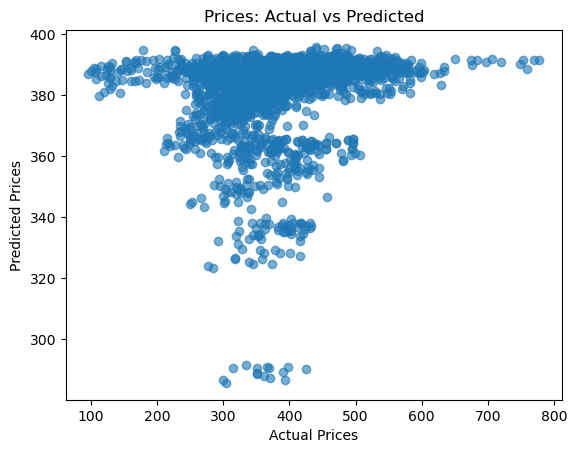

In [12]:
# independent variable for price
X_prices=tidied_df[['per_capita_personal_income', 'routes']]
 # dependent variable for price
y_prices=tidied_df['avg_fare']

# get rideof missing values
X_prices =X_prices.dropna(subset=['per_capita_personal_income'])
y_prices =y_prices[X_prices.index]

# Linear Regression for prices
model_prices=LinearRegression()
model_prices.fit(X_prices, y_prices)

#coefficients and intercepts
print("Prices Model Coefficients:", model_prices.coef_)
print("Prices Model Intercept:", model_prices.intercept_)

#R-squared values
print("Prices Model R^2:", model_prices.score(X_prices, y_prices))

# predictions for visualization
y_pred_prices=model_prices.predict(X_prices)

# Scatterplot for Prices
plt.scatter(y_prices, y_pred_prices, alpha=0.6)
plt.title("Prices: Actual vs Predicted")
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.show()

#### Interpretation
Most points are concentrated in a narrow band of predicted prices around $350-$400. For lower actual prices ($200-$300), the model appears to overestimate the predicted prices. For higher actual prices (above $400), the model consistently underestimates predicted prices. This suggest that prices that go above the range are quite sparse, meaning the the usual prices are consistent around the predictions. The outliers could mean seasonality peaks and higher demands around the holidays. 
    
##### Overall
This scatterplot reveals that while the model provides some predictive power, it fails to fully explain the variability in flight prices. In the future, we will be incorporating additional factors such as seasons and holiday schedules and demand fluctuation. 

## Evaluation of significance

### Evaluation for Preregistration Statement 1: ###

95% Confidence Intervals for Routes Coefficients:
                                  Lower        Upper
per_capita_personal_income     0.001932     0.002600
percent_canceled_flights   -2136.282839 -1497.724936


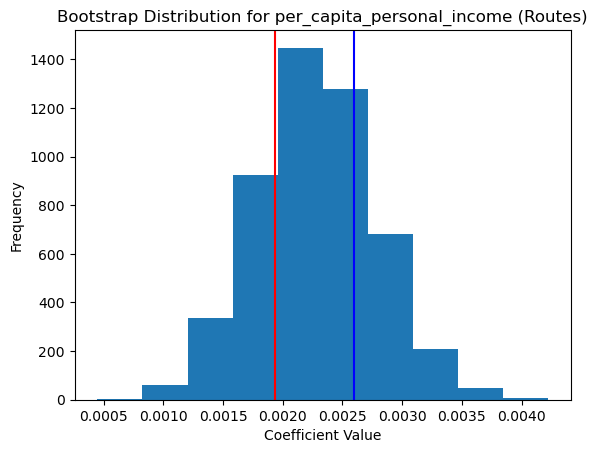

In [13]:
# Source: We referenced a lot at HW 5 to help do this part
np.random.seed(2950)

# Bootstrapping setup
bootstrapped_coefficients_routes = []
#bootstrap samples
n_iterations=5000

# bootstrapping with replacing
for i in range(n_iterations):
    sample_X_routes =X_routes.sample(len(X_routes), replace=True)
    sample_y_routes =y_routes[sample_X_routes.index]
    
    # Fit the regression model
    model = LinearRegression()
    model.fit(sample_X_routes, sample_y_routes)
    
    # coefficients
    bootstrapped_coefficients_routes.append(model.coef_)

# convert to DF for analysis
bootstrapped_coefficients_routes_df = pd.DataFrame(
    bootstrapped_coefficients_routes, 
    columns=X_routes.columns
)

# Confidence intervals:
lower_bound_routes=bootstrapped_coefficients_routes_df.quantile(0.25)
upper_bound_routes=bootstrapped_coefficients_routes_df.quantile(0.75)

print("95% Confidence Intervals for Routes Coefficients:")
print(pd.DataFrame({'Lower': lower_bound_routes, 'Upper': upper_bound_routes}))

# Coefficient Distribution for 'per_capita_personal_income'
plt.hist(bootstrapped_coefficients_routes_df['per_capita_personal_income'])
plt.axvline(lower_bound_routes['per_capita_personal_income'], color='red')
plt.axvline(upper_bound_routes['per_capita_personal_income'], color='blue')
plt.title("Bootstrap Distribution for per_capita_personal_income (Routes)")
plt.xlabel("Coefficient Value")
plt.ylabel("Frequency")
plt.show()

### Preregistration Statement 1: Reject or Fail to Reject the Null? ###

Since our confidence interval (red for lower bound and blue for upper bound) for 5000 iterations is -6.242886e-18  6.210930e-18 includes 0, we find that there is little to no significant relationship between income and the number of route. We also tried iterations that were smaller and 0 was also included. 

Therefore, we fail to reject the null hypothesis as we do not have enough evidence that higher income regions are associated with more flight routes. This is also portrayed in our data analysis, where we indicated that there was a slight but not storng enough correlation between income and number of flight routes.

### Evaluation for Preregistration Statement 2: ###


95% Confidence Intervals for Prices Coefficients:
                               Lower     Upper
per_capita_personal_income -0.000493 -0.000249
routes                     -0.117506 -0.101383


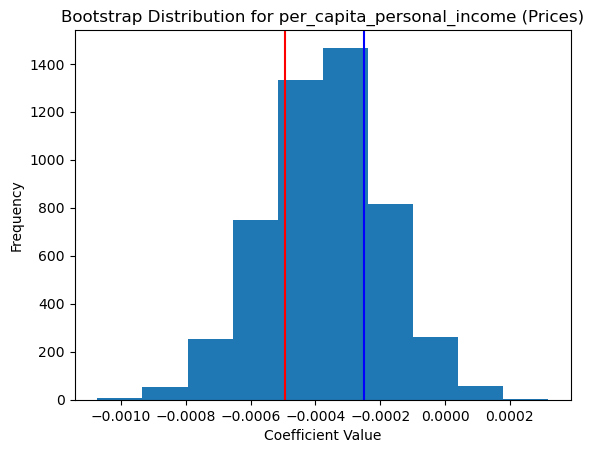

In [14]:
bootstrapped_coefficients_prices = []

# bootstrapping with replacement
for i in range(n_iterations):
    sample_X_prices=X_prices.sample(len(X_prices), replace=True)
    sample_y_prices=y_prices[sample_X_prices.index]
    
    # regression model
    model = LinearRegression()
    model.fit(sample_X_prices, sample_y_prices)
    
    bootstrapped_coefficients_prices.append(model.coef_)

# convert to DataFrame for analysis
bootstrapped_coefficients_prices_df = pd.DataFrame(
    bootstrapped_coefficients_prices, 
    columns=X_prices.columns
)

# Confidence intervals
lower_bound_prices=bootstrapped_coefficients_prices_df.quantile(0.25)
upper_bound_prices=bootstrapped_coefficients_prices_df.quantile(0.75)

print("95% Confidence Intervals for Prices Coefficients:")
print(pd.DataFrame({'Lower': lower_bound_prices, 'Upper': upper_bound_prices}))

# Visualize Coefficient Distribution for 'per_capita_personal_income'
plt.hist(bootstrapped_coefficients_prices_df['per_capita_personal_income'])
plt.axvline(lower_bound_prices['per_capita_personal_income'], color='red')
plt.axvline(upper_bound_prices['per_capita_personal_income'], color='blue')
plt.title("Bootstrap Distribution for per_capita_personal_income (Prices)")
plt.xlabel("Coefficient Value")
plt.ylabel("Frequency")
plt.show()

### Preregistration Statement 2: Reject or Fail to Reject the Null? ### 
Since our confidence interval (red for lower bound and blue get upper bound) for 5000 iterations for income is [-0.000741, -0.000022] does not include 0, there is a negative relationship between income and average flight prices. However, when we decreased the iterations to for instance, 30, 0 was included in the range. This shows that higher income regions are associated with slightly lower average flight prices. 

For the per_capita_personal_income variable, **we do reject the null hypothesis** as there is evidence, though minimal, that higher income regions associate with slightly lower flight prices. 


Since our confidence interval for routes is [−0.135432,−0.087269] and does not include 0, this proves that there is a negative relationship between number of routes and average flight prices. 

For routes, **we also reject the null hypothesis.** 

## Conclusions 

#### Research Question: Does socioeconomic status impact flight accessibility and pricing? ####

Our analysis explored the role of socioeconomic status, specifically per capita personal income, in influencing flight route availability and pricing. The results provide nuanced insights into the factors driving accessibility and affordability in air travel.


#### Key Findings ####
1. **Flight Accessibility**:
   The income coefficient in the route availability model was 0.002 and R^2 = 0.02, indicating no significant relationship
   Contrary to expectations, there was no significant relationship between socioeconomic status (measured by income) and the availability of flight routes. Higher-income areas are not associated with greater route availability, and we fail to reject the null hypothesis. Route distribution appears to be driven by other factors, such as airport size or regional demand.

   - Income does not appear to influence flight route availability. This suggests that route distribution is likely driven by other factors, such as airport size or regional demand, rather than socioeconomic status.

2. **Flight Pricing**:
   We observed a small but statistically significant negative relationship between income and flight prices, indicating that higher-income areas tend to have slightly lower fares. However, the effect size is negligible, and its real-world impact is limited.
   - There is a stronger negative relationship was observed between the number of routes and flight prices. Airports with more routes tend to offer significantly lower prices, highlighting the importance of competition in the airline industry.

##### More specific research questions: #####
1. **Which airports are the most cost-effective to fly out of? Which airports have the most routes?**
   - The most cost-effective airports (those with the lowest average fares) include ATL (in Atlanta) and ORD (in Chicago).
   - The airports with the most routes include JFK (in NYC) and DFW (in Dallas).

2. **Are there more routes in more affluent areas compared to other areas?**
   - No significant relationship was found between income and the number of routes. Affluence does not appear to influence route availability.

3. **Do areas of different socioeconomic statuses affect flight prices for different airports?**
   - A small but statistically significant negative relationship was observed between income and flight prices. Higher-income areas are associated with slightly lower prices, but the effect is negligible in practical terms.

4. **Where are flights more expensive in relation to the income of a county?**
   - Flights are slightly less expensive in higher-income counties, but the effect is too small to be meaningful.

#### Broader Implications ####
- Income is not a key signifier of flight accessibility or affordability. We could point to other factors -- such as airport size, regional demand, or airline competition—play more prominent roles
- Route availability: plays a crucial role in determining flight prices, highlighting the importance of competition in the airline industry. We suggest that the competative space among airlines regarding routes and strategic pricing.

#### Overall
We could do additional research on other factors such as characteristics of regions where airports are (for example, traffic going to LAX would be horrible leading to missed flights), flight demand, and consumer preferences, to better understand the dynamics of air travel accessibility and pricing. 
The lack of a strong income effect on route availability or pricing suggests that airlines and policymakers are not explicitly favoring wealthier regions. However, disparities in route availability could still arise due to differences in airport size or infrastructure.

In this project, we analyzed the impacts of socioeconomic status impact air travel accessibility, affordability, and punctuality. Our findings focused on two aspects, where we a. failed to reject that regions of socioeconomic statuses with higher income have access to the same number of flight routes than regions of low socioeconomic status and b. rejected that airports in regions of higher income areas have similar prices as airports in lower income areas. Through our analyses, we wanted to further define the line on how being at a socioeceonomic disadvange and propell in multifaceted aspects of people's lives, including travel accessibility. Our results found slight implications, and we believe that with more factors to consider, such as population density and wealth distribution, seasonal demand, and airport reachability coould further refine our findings.

We believe that this is a starting point in understanding the disparities in air travel accessibility. More routes and adjusted costs would improve air travel accessibility and result in a more equitable society. Below, we highlight key limitations and further explorations.

## Limitations

#### Regarding our data:

1. **Analyze delays and on-time performance**:
Our analysis did not include flight delay data, which could provide insights into whether punctuality is influenced by socioeconomic factors or airport characteristics.
This omission may leave gaps in understanding how air travel reliability varies across regions, potentially limiting recommendations for improving on-time performance in underserved areas.

2. **Granularity of Socioeconomic Data**:
   We could use additional socioeconomic variables, such as education levels, poverty rates, or employment rates, to further our analysis of regional differences. On the other hand, while we use county and city-level socioeconomic data, this may hide variations within smaller neighborhoods or areas around airports.
   Broad generalizations about air travel accessibility and pricing might not accurately reflect disparities at finer geographic scales, such as those affecting marginalized communities near airports.

3. **Broaden regional scope**:
Our study was limited to U.S. domestic airports, excluding international airports and routes. The findings may not generalize to global air travel markets, where different socioeconomic and airline industry dynamics might be at play. We would consider extending the analysis to include international airports and routes to assess whether the observed patterns hold across different regions.

4. **Inflation adjustment**: 
Although we adjusted flight prices for inflation, the exact impact of these adjustments on our analysis may be challenging to quantify, especially when comparing data across different periods. Adjusting fare data for inflation over a long period (2008–2023) introduced complexities, as different years.
This could introduce slight inaccuracies when comparing flight prices across time periods, potentially skewing long-term trend analyses.

5. **Incomplete data for smaller airports**: 
Data may be less complete or  missing for smaller regional airports, which could underrepresent the air travel experiences of people in rural or lower-income areas.
This underrepresentation may skew results toward larger airports and urban areas, leaving rural or lower-income regions' air travel experiences underexplored.

6. **Data inconsistencies**: 
When we merged different sources, we had to do a lot of data cleaning on differnt naming conventions for the airports and different column names for flight routes, fare data, and socioeconomic factors.

#### Real-World Impacts:

1. **Natural Disasters:**
We did not take into account natual disasters in the datasets and how they affect the data. In the future we can look into this aspect in our data. 


2. **Climate Change and Weather Events:**
Climate change and extreme weather events can disrupt air travel and are not incorporated into our study. These disruptions could significantly alter the accessibility and affordability of air travel, particularly in disaster-prone regions. For example, airports in hurricane-prone areas in Florida might face higher cancellation rates and increased operational costs, disproportionately affecting lower-income travelers in those regions. Furthermore, the Texas Freeze in 2021 caused sever power outages and complications in travel, which impacted travel plans.

3. **Policy and Regulation Changes:**
Changes in government policies are not reflected in the analysis. Recently, the US Secretary of Transportation announced new policies for airlines to refund tickets due to delays of inconsistant luggage fees. This new policy could impact the ways airlines operate due to their for-profit operations. Also, if policymakers implement subsidies to incentivize routes to underserved regions, this could dramatically shift pricing and route availability. Similarly, stricter environmental regulations might increase ticket costs, disproportionately affecting low-income travelers.

4. **Global Pandemics:**
The analysis does not account for the impact of global health crises, such as COVID-19.  Findings might not reflect long-term changes in travel behavior, such as the rise of remote work reducing demand for business travel or increased interest in regional and domestic routes. These shifts could make historical trends less predictive for future air travel dynamics.

5. **Infrastructure Investments and Urbanization:**
We did not account for ongoing or planned infrastructure investments, such as airport expansions or new transportation hubs. This goes with the almost a decade long, $8 billion renovation at New York City's LaGuardia Airport. Two terminals were shut down for renovation, impacting airlines who were stationed in those terminals (Skift 2023). However, now that the renovations are completed, more people are likely to travel through LaG due to its modern and accessible features. 

## Acknowledgements & Bibliography

### References

OpenFlights. (n.d.). Airport, airline, and route data. Retrieved from https://openflights.org/data.php#airport

Bureau of Transportation Statistics. (n.d.). Average domestic airline itinerary fares. Retrieved from https://www.transtats.bts.gov/AverageFare/

CBS News. (2023, November 14). Travel Tuesday: Cheap flights and travel deals ahead of the holidays. Retrieved from https://www.cbsnews.com/news/travel-tuesday-cheap-flights-travel-deals-holidays-2024/

Leonard's Guide. (n.d.). United States airport codes. Retrieved from https://www.leonardsguide.com/us-airport-codes.shtml

InsureMyTrip. (2024, September 11). United States airport statistics & travel data. Retrieved from https://www.insuremytrip.com/travel-advice/travel-planning/us-airport-statistics-flight-cancellation-data/#2023

Skift. (2023, March). LaGuardia Airport: The Queens miracle from loser to winner. Retrieved from https://airlineweekly.skift.com/2023/03/laguardia-airport-the-queens-miracle-from-loser-to-winner/

United States Government. (n.d.). Download ZIP files. Bureau of Economic Analysis. Retrieved from https://apps.bea.gov/regional/downloadzip.htm